## Filippo Ziliotto

### Mat: 2017425

# Variational Autoencoder

This notebook is related to the last point of the homework, where we was asked to code a variational autoencoder

In [17]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import plotly.express as px
import pathlib
import os
import time
import pandas as pd
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils
from torchvision import transforms
import torchvision
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from Pytorchtools import EarlyStopping
from sklearn.model_selection import KFold
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import PercentilePruner
import pytorch_lightning as pl
from torch.nn import functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch import autograd
from torch.autograd import Variable
import gc
import random # this module will be used to select random samples from a collection
from tqdm.notebook import tqdm # this module is useful to plot progress bars
import pathlib
import plotly
import imageio
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Check if the GPU is available
device = str(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f'Selected device: {device}')

Selected device: cpu


In [3]:
train_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,),(0.5,))
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST('FashionMNIST', train=True,
                                                  download=True, transform=train_transform)

test_dataset  = torchvision.datasets.FashionMNIST('FashionMNIST', train=False,
                                                  download=True, transform=test_transform)

In [5]:
train_size = int(0.8 * len(train_dataset)) #80% for the training 20% for the validation
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

## Architecture

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 8, kernel_size=(3,3), padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels = 16, kernel_size=(3,3), padding=1, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels = 32, kernel_size=(3,3), padding=0, stride=2)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fc1     = nn.Linear(32*3*3, 50)
        self.fc_mu   = nn.Linear(50, latent_dim)  #conv layers goes into two branches mu,sigma
        self.fc_logvar   = nn.Linear(50,latent_dim)
        
        #Activation definitions
        self.relu  = nn.ReLU()

        print('Encoder Initialized')

    def forward(self, x, additional_out=False):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x_mu = self.fc_mu(x) #x goes into mu
        x_logvar = self.fc_logvar(x) #x goes into sigma
        
        return x_mu, x_logvar

In [8]:
class Decoder(nn.Module):
    def __init__(self,latent_dim):

        super().__init__()

        self.fc1   = nn.Linear(latent_dim, 50)
        self.fc2   = nn.Linear(50, 32*3*3)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))        

        self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels = 16,
                                        kernel_size=(3,3), padding=0, stride = 2, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels = 8,
                                        kernel_size=(3,3), padding=1, stride = 2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=8, out_channels = 1,
                                        kernel_size=(3,3), padding=1, stride = 2, output_padding=1)

        #Activation definitions
        self.relu  = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        print('Decoder Initialized')

    def forward(self, x, additional_out=False):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.sigmoid(x) #output values between [0,1]
        return x
    


In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
latent_dim = 2
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

# Move both the encoder and the decoder to the selected device
print(encoder.to(device))
print(decoder.to(device))

Encoder Initialized
Decoder Initialized
Encoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=288, out_features=50, bias=True)
  (fc_mu): Linear(in_features=50, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
)
Decoder(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=288, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv3): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (relu): Re

## Training

In [10]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,encoder, decoder):   
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def latent_sampler(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_() #var = std^2
        eps = torch.empty_like(std).normal_() # sample from gaussian G(0,1)
        x_hat = eps.mul(std).add_(mu) #mul = multiply(eps,std) , add_=add(mu) std*eps +mu
        return x_hat        
        
        
    def forward(self, x):
        
        latent_mu, latent_logvar = self.encoder(x)  
        latent_z = self.latent_sampler(latent_mu, latent_logvar)
        x = self.decoder(latent_z)
        return x, latent_mu, latent_logvar
    


In [12]:
def vae_loss(x_hat, x, mu, logvar, beta):
    
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kldivergence

In [49]:

def train_epoch(vae, encoder, decoder, train_dataloader, val_dataloader, num_epochs, device, beta):
    beta = beta #disentagled autoencoder
    TRAINING_LOSS = []
    VALIDATION_LOSS = []
    for i in range(num_epochs):
        
        
        num_batches = 0
        train_loss=[]   
        loss_batch=0
        for image, label in tqdm(train_dataloader):
                     
            x_batch = image.to(device)
            x_label = label.to(device)
            
            out, mu, logvar = vae.forward(x_batch)
            
            #compute loss
            loss = vae_loss(out, x_batch, mu, logvar, beta)
            
            # Backpropagation
            optimizer.zero_grad()
            
            # Save train loss for this batch
            loss_batch += loss.item()
            train_loss.append(loss_batch)
            num_batches += 1
            
            # Backpropagation
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
        train_loss = np.mean(np.array(train_loss))/num_batches
        TRAINING_LOSS.append(train_loss)
        
        num_batches=0
        valid_loss = []
        loss_batch=0
        vae.eval()
        with torch.no_grad():
            
            for image, label in tqdm(val_dataloader):
            
                x_batch = image.to(device)
                x_label = label.to(device)          

                out, mu, logvar = vae.forward(x_batch)
            
                loss_ = vae_loss(out, x_batch, mu, logvar, beta)
                        
                loss_batch += loss_.item()
                valid_loss.append(loss_batch)
                num_batches+=1
            
                lol = np.mean(np.array(valid_loss))/num_batches
                VALIDATION_LOSS.append(lol)
            

        print('Epoch {}'.format(i+1))
        print('Training loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(lol))
        print('--------------')
        
        
    return TRAINING_LOSS, VALIDATION_LOSS
            


In [52]:
vae = VariationalAutoEncoder(encoder, decoder)
print(vae)

Encoder Initialized
Decoder Initialized
VariationalAutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=288, out_features=50, bias=True)
    (fc_mu): Linear(in_features=50, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=50, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=288, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (conv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(8, 1, kernel

In [53]:
num_epochs = 20
optimizer = torch.optim.Adam(params=vae.parameters(), lr=5e-4, weight_decay=1e-5)
train_loss, val_loss = train_epoch(vae, encoder, decoder, train_dataloader,val_dataloader, num_epochs, 'cpu', beta=2)

  1%|▌                                                                                 | 5/750 [00:00<00:16, 44.95it/s]

Epoch 1
Training loss: 2272.591067671875
Validation loss: 1307.2014695595378
--------------


  0%|▎                                                                                 | 3/750 [00:00<00:31, 23.63it/s]

Epoch 2
Training loss: 1257.0702643919271
Validation loss: 1212.3579642044144
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:21, 34.64it/s]

Epoch 3
Training loss: 1191.968312265191
Validation loss: 1182.3522194879204
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:20, 36.70it/s]

Epoch 4
Training loss: 1158.3627121495226
Validation loss: 1147.3321846149906
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:18, 41.00it/s]

Epoch 5
Training loss: 1138.382097268012
Validation loss: 1134.470654892997
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:18, 39.90it/s]

Epoch 6
Training loss: 1121.1744018860677
Validation loss: 1117.3139993159034
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:19, 38.36it/s]

Epoch 7
Training loss: 1107.8530375533853
Validation loss: 1107.6907663893624
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:18, 41.34it/s]

Epoch 8
Training loss: 1099.7077667154947
Validation loss: 1104.4317960035428
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:17, 42.73it/s]

Epoch 9
Training loss: 1091.6195555240886
Validation loss: 1102.2399624245584
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:16, 44.27it/s]

Epoch 10
Training loss: 1087.4777081026475
Validation loss: 1101.3928759442351
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:21, 34.02it/s]

Epoch 11
Training loss: 1085.9112382554254
Validation loss: 1103.0509625698658
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:19, 37.98it/s]

Epoch 12
Training loss: 1083.260856734375
Validation loss: 1084.8906701857711
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:19, 38.49it/s]

Epoch 13
Training loss: 1079.031793517578
Validation loss: 1088.1382857184974
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:19, 37.61it/s]

Epoch 14
Training loss: 1072.0313295991753
Validation loss: 1081.1137468951922
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:21, 34.68it/s]

Epoch 15
Training loss: 1072.3224265746528
Validation loss: 1073.5362068234983
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:19, 38.40it/s]

Epoch 16
Training loss: 1068.468504595703
Validation loss: 1077.1474429847644
--------------


  1%|▍                                                                                 | 4/750 [00:00<00:19, 37.62it/s]

Epoch 17
Training loss: 1067.0975657239583
Validation loss: 1066.253758388604
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:19, 38.89it/s]

Epoch 18
Training loss: 1064.3926753398437
Validation loss: 1064.115986960028
--------------


  1%|▌                                                                                 | 5/750 [00:00<00:16, 43.93it/s]

Epoch 19
Training loss: 1060.9090925748696
Validation loss: 1073.225191510927
--------------


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 78.69it/s]

Epoch 20
Training loss: 1058.8339724646269
Validation loss: 1068.0828414613059
--------------


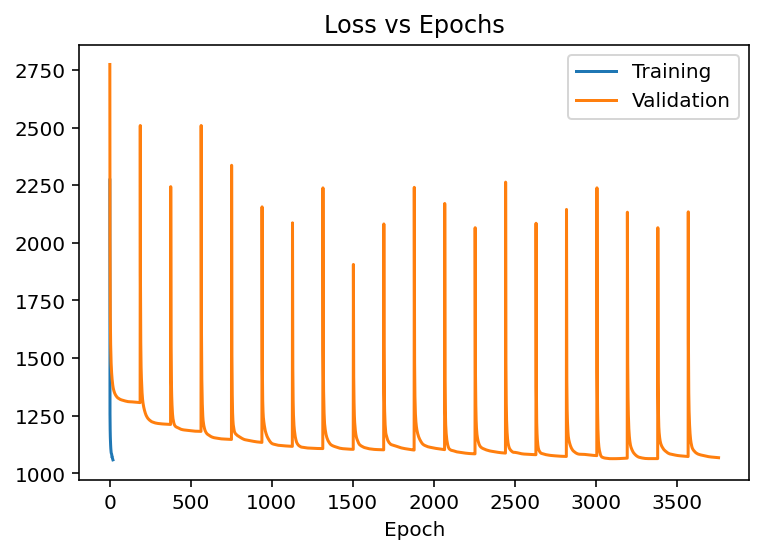

In [54]:
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [73]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='viridis')

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)), cmap='viridis')
        plt.show()

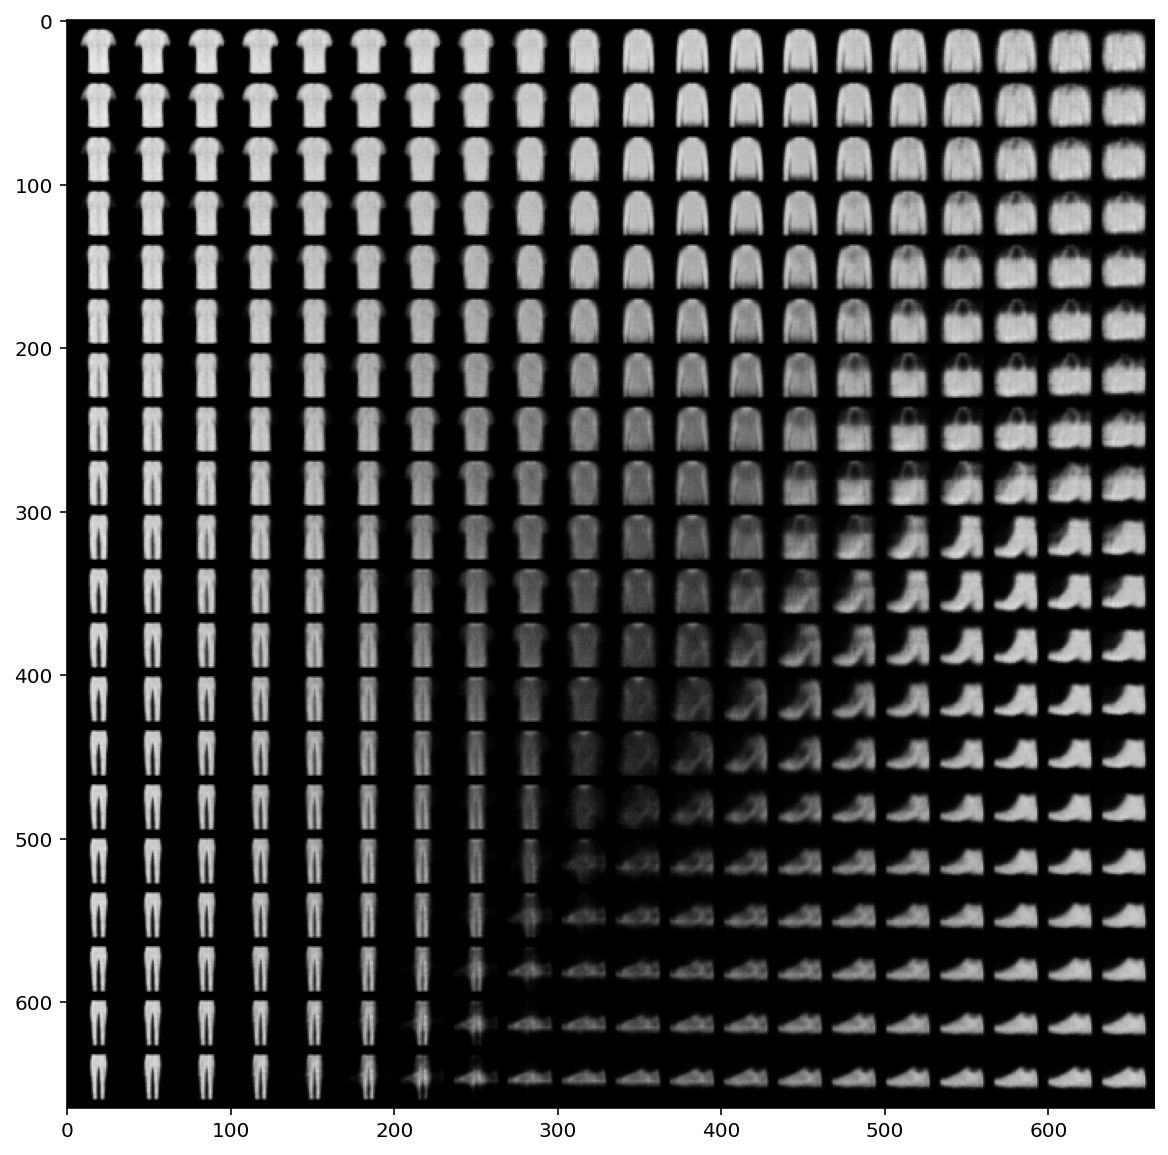

In [74]:
# load a network that was trained with a 2d latent space
if latent_dim != 2:
    print('Please change the parameters to two latent dimensions.')
    
vae.eval()
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-2,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

# GAN implementation

In [ ]:
#Load the data

mnist = FashionMNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [ ]:
#Viewing the data

img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

In [ ]:
#When viewing the images we would like to de normalize it 
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
#View the image on screen

import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [ ]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.to(device)

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.to(device)

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
#Training the discriminator

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # So essentially, you use the given set of real images and feed it to the discriminator and train to understand the pattern of the real images.
    # Then, you generate a bunch of fake images and then feed them to the discriminator to train them to understand the pattern of the fake images.

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')